In [2]:
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import seaborn as sns
sns.set()
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise, Input, PReLU, Activation, Concatenate
from keras.models import load_model
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

In [4]:
df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df[df.z > 10]
df = df.dropna()

In [30]:
# large-scale parameters, should be included
F1 = [
    'dewpoint', 'spec_hum', 'press', 'temp', 'air_dens', 
    'virtual_temp', 'rel_hum', 'rain', 'z', 'wind', 'soil_temp'
]

# radiation, no idea but probably should not include
F2 = [
    'co2flux', 'soilheat', 'netrad'
]

# fluxes, better if not included
F3 = [
    'H', 'LE',
]

# we must be desperate to use these to make it work
F4 = [
    'lval', #'zL', 'ustar'
]

features = F1 + F2 #+ F3 + F4

target = 'phi_m'

In [31]:
def make_index(dtimes, interval):
    # returns a tuple index_above, index_below
    # index_above[i] is the largest i
    # such that dtimes[index_above[i]] - dtimes[i] < interval
    # index_below[i] is the smallest i
    # such that dtimes[i] - dtimes[index_below[i]] < interval
    # dtimes must be already sorted!
    index_below, index_above = np.zeros(
        (2, len(dtimes)), dtype=np.int
    ) - 1
    
    for i, x in enumerate(dtimes):
        j = index_below[i - 1] if i > 0 else 0
        while x - dtimes[j] > interval:
            j += 1

        index_below[i] = j
        index_above[j] = i

    last_above = index_above[0]
    for i in range(len(dtimes)):
        if index_above[i] < 0:
            index_above[i] = last_above
        else:
            last_above = index_above[i]
    
    return index_above, index_below


def compute_trend(df, columns, interval=3600):
    df = df.sort_values('datetime')
    for z in df.z.unique():  
        sorted_df = df[df.z == z]
        index_above, index_below = make_index(sorted_df.datetime.values, interval)

        for col in columns:
            val_above = sorted_df.iloc[index_above][col].values
            val_below = sorted_df.iloc[index_below][col].values

            time_above = sorted_df.iloc[index_above].datetime.values
            time_below = sorted_df.iloc[index_below].datetime.values

            trend = 2 * interval * (val_above - val_below) / (time_above - time_below)

            df.loc[df.z == z, col + '_trend'] = trend
            #df.loc[df.z == z, col + '_trend_1'] = sorted_df.index[index_above]
            #df.loc[df.z == z, col + '_trend_2'] = sorted_df.index[index_below]
            #df.loc[df.z == z, col + '_trend_3'] = time_above - time_below

    return df, [col + '_trend' for col in columns]


use_trend = True
if use_trend:
    ddf, added_cols = compute_trend(df, [
        f.replace('_trend', '') for f in features
        if f != 'z'
    ])
    ddf = ddf.dropna()
    features.extend(added_cols)
else:
    features = [f for f in features if 'trend' not in f]
    ddf = df


features = list(set(features))    
print('using features', features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


using features ['press', 'z', 'dewpoint_trend', 'rain', 'rain_trend', 'wind', 'soilheat', 'virtual_temp', 'air_dens_trend', 'co2flux_trend', 'netrad_trend', 'spec_hum', 'netrad', 'air_dens', 'rel_hum', 'press_trend', 'virtual_temp_trend', 'temp', 'temp_trend', 'wind_trend', 'rel_hum_trend', 'spec_hum_trend', 'soil_temp_trend', 'co2flux', 'dewpoint', 'soilheat_trend', 'soil_temp']


In [32]:
test_ds = np.random.choice(ddf.ds.unique(), 12, replace=False)
test_mask = ddf.ds.isin(test_ds)
train_x, train_y = ddf[~test_mask][features], ddf[~test_mask][target]
test_x, test_y = ddf[test_mask][features], ddf[test_mask][target]

tdf = ddf.sample(100000)
train_x, train_y = tdf[features], tdf[target]
tdf = ddf.sample(10000)
test_x, test_y = tdf[features], tdf[target]

print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 100000, testing with 10000


In [33]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

norm_train_x = (train_x - mean_x) /  std_x
norm_test_x = (test_x - mean_x) / std_x

norm_train_y = (train_y - mean_y) / std_y
norm_test_y = (test_y - mean_y) / std_y

In [34]:
assert np.all(np.isfinite(norm_train_x))

In [35]:
def build_model(sizes):
    # every element in sizes specifies a layer
    #   negative number: skip connection of -n layers
    #                    successive skips are aggregated
    #                    into a single layer
    #   0<n<1: dropout with pkeep=n
    #   >1 fully connected then prelu
    layers = [Input(shape=(len(features),))]
    i = 0
    while i < len(sizes):
        num = sizes[i]
        if num < 0:
            skip = [layers[-1]]
            while i < len(sizes) and sizes[i] < 0:
                skip.append(layers[sizes[i] - 1])
                i += 1
            layer = Concatenate()(skip)
            i -= 1
        elif num < 1:
            layer = Dropout(num)(layers[-1])
        else:
            layer = PReLU()(
                Dense(num)(
                    layers[-1]
                )
            )

        layers.append(layer)
        i += 1

    layers.append(Dense(1)(layers[-1]))
        
    opt = Adam(lr=0.001)
    model = Model(inputs=layers[0], outputs=layers[-1])
    model.compile(loss='mse', optimizer=opt)
    return model


model = build_model([
    512, 512, -2, 0.5,
    256, 256, -4, 0.5,
    128, 128, -4, 0.5,
    64, 64, -4, 0.5,
    32, 32, -4, 0.5,
    16, 16, -4,
    16, 16, -4,
    16, 16, -4,
    8, 8, -4,
    8, 8, -4,
    8, 8,
])

model = build_model([
    1024, 0.5, 512, 0.5, 256, -2, -4, 0.5, 256, 0.5, 128, 64, 64, 32, 32, 16, 16, -4, 8, -8, 4, 2,
])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 27)           0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 1024)         28672       input_6[0][0]                    
__________________________________________________________________________________________________
p_re_lu_95 (PReLU)              (None, 1024)         1024        dense_100[0][0]                  
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 1024)         0           p_re_lu_95[0][0]                 
__________________________________________________________________________________________________
dense_101 

In [36]:
callbacks = [
    ReduceLROnPlateau(factor=0.5, verbose=1, min_lr=1e-6, patience=25),
    ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                    verbose=1, save_best_only=True),
    TensorBoard('dev/logs/', write_graph=False, write_grads=True),
    EarlyStopping(min_delta=0.0001, patience=50),
]

hist = model.fit(
    norm_train_x, norm_train_y,
    batch_size=256, epochs=500,
    shuffle=True,
    callbacks=callbacks,
    validation_data=(norm_test_x, norm_test_y)
)

Train on 100000 samples, validate on 10000 samples
Epoch 1/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.3784
Epoch 00001: val_loss improved from inf to 0.31356, saving model to dev/models/weights-w.0001-0.3136.hdf5
100000/100000 [==============================] - 15s 149us/step - loss: 0.3777 - val_loss: 0.3136
Epoch 2/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.2715
Epoch 00002: val_loss improved from 0.31356 to 0.24964, saving model to dev/models/weights-w.0002-0.2496.hdf5
100000/100000 [==============================] - 6s 61us/step - loss: 0.2715 - val_loss: 0.2496
Epoch 3/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.2552
Epoch 00003: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.2550 - val_loss: 0.2652
Epoch 4/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.2475
Epoch 00004: val_loss improved from 0.24964 to 0.23841, saving model 

Epoch 33/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.2071
Epoch 00033: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.2071 - val_loss: 0.2099
Epoch 34/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.2068
Epoch 00034: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.2066 - val_loss: 0.2110
Epoch 35/500
 99840/100000 [============================>.] - ETA: 0s - loss: 0.2057
Epoch 00035: val_loss did not improve
100000/100000 [==============================] - 6s 61us/step - loss: 0.2056 - val_loss: 0.2158
Epoch 36/500
 99072/100000 [============================>.] - ETA: 0s - loss: 0.2051
Epoch 00036: val_loss did not improve
100000/100000 [==============================] - 6s 62us/step - loss: 0.2054 - val_loss: 0.2062
Epoch 37/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.2049
Epoch 00037: val_loss improved from 0.2

Epoch 69/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1874
Epoch 00069: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.1874 - val_loss: 0.2007
Epoch 70/500
 99072/100000 [============================>.] - ETA: 0s - loss: 0.1859
Epoch 00070: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.1861 - val_loss: 0.2050
Epoch 71/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.1877
Epoch 00071: val_loss improved from 0.19826 to 0.19604, saving model to dev/models/weights-w.0071-0.1960.hdf5
100000/100000 [==============================] - 6s 62us/step - loss: 0.1876 - val_loss: 0.1960
Epoch 72/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1867
Epoch 00072: val_loss did not improve
100000/100000 [==============================] - 6s 61us/step - loss: 0.1867 - val_loss: 0.1979
Epoch 73/500
 99840/100000 [========================

Epoch 106/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1730
Epoch 00106: val_loss did not improve
100000/100000 [==============================] - 6s 61us/step - loss: 0.1731 - val_loss: 0.1983
Epoch 107/500
 99840/100000 [============================>.] - ETA: 0s - loss: 0.1721
Epoch 00107: val_loss did not improve
100000/100000 [==============================] - 6s 61us/step - loss: 0.1721 - val_loss: 0.1939
Epoch 108/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.1727
Epoch 00108: val_loss did not improve
100000/100000 [==============================] - 6s 61us/step - loss: 0.1728 - val_loss: 0.2003
Epoch 109/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1712
Epoch 00109: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.1712 - val_loss: 0.2010
Epoch 110/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1717
Epoch 00110: val_loss did not impr

Epoch 142/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.1498
Epoch 00142: val_loss did not improve
100000/100000 [==============================] - 6s 64us/step - loss: 0.1497 - val_loss: 0.1929
Epoch 143/500
 99840/100000 [============================>.] - ETA: 0s - loss: 0.1500
Epoch 00143: val_loss did not improve
100000/100000 [==============================] - 6s 63us/step - loss: 0.1499 - val_loss: 0.1968
Epoch 144/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1497
Epoch 00144: val_loss did not improve
100000/100000 [==============================] - 7s 72us/step - loss: 0.1497 - val_loss: 0.2024
Epoch 145/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.1502
Epoch 00145: val_loss did not improve
100000/100000 [==============================] - 7s 69us/step - loss: 0.1502 - val_loss: 0.1919
Epoch 146/500
 99840/100000 [============================>.] - ETA: 0s - loss: 0.1473
Epoch 00146: val_loss did not impr

Epoch 179/500
 99072/100000 [============================>.] - ETA: 0s - loss: 0.1387
Epoch 00179: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.1387 - val_loss: 0.1935
Epoch 180/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1404
Epoch 00180: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.1404 - val_loss: 0.1957
Epoch 181/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1402
Epoch 00181: val_loss did not improve
100000/100000 [==============================] - 6s 62us/step - loss: 0.1402 - val_loss: 0.1906
Epoch 182/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.1402
Epoch 00182: val_loss did not improve
100000/100000 [==============================] - 6s 62us/step - loss: 0.1402 - val_loss: 0.1899
Epoch 183/500
 99584/100000 [============================>.] - ETA: 0s - loss: 0.1388
Epoch 00183: val_loss did not impr

Epoch 216/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.1283
Epoch 00216: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.1284 - val_loss: 0.1937
Epoch 217/500
 99328/100000 [============================>.] - ETA: 0s - loss: 0.1288
Epoch 00217: val_loss did not improve
100000/100000 [==============================] - 6s 60us/step - loss: 0.1288 - val_loss: 0.1900


In [37]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

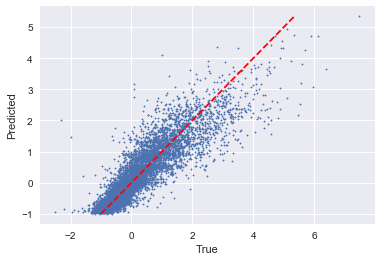

Explained variance 0.8126862827371544
Mean absolute error 0.5067814082056854
Mean squared error 0.6154612620505349
Median absolute error 0.31949133197752677
R2 score 0.8120493996995073
Mean absolute percent error [96.24253]


In [38]:
best_model = load_model('dev/models/weights-w.0167-0.1884.hdf5')
y_pred = best_model.predict(norm_test_x)

# denormalize
test_deno = norm_test_y * std_y + mean_y
pred_deno = y_pred * std_y + mean_y

plot_preds(y_pred, norm_test_y)

print('Explained variance', metrics.explained_variance_score(test_deno, pred_deno))
print('Mean absolute error', metrics.mean_absolute_error(test_deno, pred_deno))
print('Mean squared error', metrics.mean_squared_error(test_deno, pred_deno))
print('Median absolute error', metrics.median_absolute_error(test_deno, pred_deno))
print('R2 score', metrics.r2_score(test_deno, pred_deno))
mape = 100 * sum(abs((yt - yp) / yt) for yt, yp in zip(test_deno, pred_deno)) / len(test_deno)
print('Mean absolute percent error', mape)